In [48]:
import yaml
import os
from pathlib import Path
import pandas as pd
import struct
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import re

# also: cd hammer && pip install -e . 

# Setup

In [49]:
# experiment setup
PDK = 'sky130'
CLOCK_PERIOD = 10 if PDK == 'sky130' else 2 # ns

# generate custom make str for each test
make_extra = f"pdk={PDK}"
if PDK == 'intech22': make_extra += f" PDK_CONF=experiments/intech22.yml"

# useful paths
energy_char_dpath = Path(os.getcwd()).parent
tests_dpath = energy_char_dpath/f'experiments/tests-{PDK}'
tests_dpath

PosixPath('/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130')

# Generate experiment files

In [50]:
# get pdk clock periods, paths
PDKs = ["sky130"]
test_paths = {}
for pdk in PDKs:
    test_paths[pdk] = energy_char_dpath/f'experiments/tests-{pdk}'

operations = ['fpu_addder']
op_to_inst = {'fpu_addder':'fpu_adder0'}
num_inputs = 50
widths = [8]
mantissa = {8:3, 16:10, 32:23, 64:52}
activity_factors = [0.1, 0.3, 0.7, 1.0] # eventually include: 0.3,0.7
#activity_factors = [1.0]
clock_periods = [CLOCK_PERIOD] # ns, clock periods to apply to all designs; eventually try sweeping this

design_minclock_dict = {}
# optional:
# design_minclock_dict={'add4': 4, 'add8': 4, 'add16': 4, 'add32': 4, 'add64': 4, 'mul4': 5, 'mul8': 5, 'mul16': 6, 'mul32': 6, 'mul64': 5}

'''
tests dict
  name format: <design>-<test_name>
      inputs: list, where each item is a tuple of items per line in input.txt
      defines: for verilog
'''

'\ntests dict\n  name format: <design>-<test_name>\n      inputs: list, where each item is a tuple of items per line in input.txt\n      defines: for verilog\n'

In [51]:
# # smoke test:
# operations = ['add']
# widths = [4]
# activity_factors = [0]

## Activity Factor Based Input Generation

In [52]:
def findNums(num):
	a = 0
	b = num - a
	return (a, b)

def convertStrToInt(bin):
	bin = bin[::-1]
	num = 0
	for i in range(len(bin)):
		if (bin[i] == '1'):
			num += (1 << i)
	return num

def getBias(exponent_len):
	return pow(2, (exponent_len - 1)) - 1

## convert binary string to respective floating point number
def convertStrToFPU(bin, mantissa_len):
	exponent_len = len(bin) - mantissa_len - 1
	exponent_val = pow(2, convertStrToInt(bin[1:1+exponent_len]) - getBias(exponent_len))
	sign = pow(-1, 0 if bin[0] == '0' else -1)
	mantissa_str = bin[1+exponent_len:1+exponent_len+mantissa_len]
	frac_val = 1
	for i in range(len(mantissa_str)):
		if (mantissa_str[i] == '1'):
			frac_val += pow(2, -(i + 1))
	return sign * exponent_val * frac_val


## flip the output (cur_num) given the width and activity factor (prob)
def flip_str(cur_str, width, prob):
	ret = ''
	for i in range(width):
		on = (cur_str[i] == '1')
		rand_num = random.random()
		## flip bit
		if (rand_num <= prob):
			ret += ('1' if not on else '0')
		else:
			ret += ('1' if on else '0')
	return ret

def getInputs(width, activity_factor, num_iter):
	lastBinStr = ''
	for i in range(width):
		lastBinStr += '0'
	all_strs = [lastBinStr]
	nums = [(0, 0)]
	for i in range(num_iter - 1):
		new_str = flip_str(lastBinStr, width, activity_factor)
		fpu_val = convertStrToFPU(new_str, mantissa[width])
		nums.append(findNums(fpu_val))
		lastBinStr = new_str
		all_strs.append(lastBinStr)
	return nums

In [53]:
def getMaxInputSwitching(num, operation):
    return (num, num)

def getMaxOutputSwitching(num, operation):
    if (operation == 'add'):
        a = int(num/2)
        b = num - a
        return (a, b)
    elif (operation == 'mul'):
        return (1, num)


## Generate All Testbenchs

In [54]:
def writeYaml(td):
    defines_str = '\n'.join( [ f"  - {key}={val}" for key,val in td['defines'].items() ] )
    clock_period = td["clock_period"]
    width = td["width"]
    mantissa_len = td['mantissa']
    exponent_len = td['exponent']
    delays = [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: input}}""" for i in td['input_ports']]
    delays += [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: output}}""" for i in td['output_ports']]
    delays = ',\n  '.join(delays)
    cfg = f"""\
vlsi.core.build_system: make
vlsi.inputs.power_spec_type: cpf
vlsi.inputs.power_spec_mode: auto

design.defines: &DEFINES
  - CLOCK_PERIOD={clock_period}
  - MANTISSA={mantissa_len}
  - EXPONENT={exponent_len}
{defines_str}

vlsi.inputs.clocks: [{{name: "clock", period: "{clock_period}ns", uncertainty: "100ps"}}]

vlsi.inputs.delays: [
  {delays}
]

synthesis.inputs:
  top_module: {td['top_module']}
  input_files: {td['vsrcs']}
  defines: *DEFINES

sim.inputs:
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  options: ["-timescale=1ns/10ps", "-sverilog"]
  options_meta: append
  defines: *DEFINES
  defines_meta: append
  level: rtl
  input_files: {td['vsrcs'] + td['vsrcs_tb']}

vlsi.core.power_tool: hammer.power.joules
power.inputs:
  level: rtl
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  defines: *DEFINES
  input_files: {td['vsrcs']}
  report_configs:
    - waveform_path: {td['root']}/output.fsdb
      report_stem: {td['root']}/power
      toggle_signal: {td['clock']}
      num_toggles: 1
      levels: all
      output_formats:
      - report
      - plot_profile
      - ppa
"""
    with (td['root']/'config.yml').open('w') as f:
        f.write(cfg)

In [55]:
def decimalFormat(factor):
    sf = str(factor).replace('.','p')
    #sf = sf.replace('p0','') # 1p0 --> 1
    return sf

def createTest(operation, width, factor, clock_period):
    design = f"{operation}{width}-{clock_period}ns"
    #print(decimalFormat(factor))
    test_name = f'{design}-{decimalFormat(factor)}'

    ## set inputs
    new_test = {'inputs': getInputs(width, factor, num_inputs), 'defines': dict(WIDTH=width)}

    new_test['operation'] = operation
    new_test['width'] = width
    new_test['mantissa'] = mantissa[width]
    new_test['exponent'] = (width - mantissa[width] - 1)
    new_test['output_af'] = factor

    ## verilog info
    new_test['design'] = design
    new_test['inst'] = f'/{operation}/{op_to_inst[operation]}'
    new_test['clock'] = 'clock'
    new_test['vsrcs'] = [f'src/{operation}.v']
    new_test['vsrcs_tb'] = [f'src/{operation}_tb.v']
    new_test['top_module'] = f'{operation}'
    new_test['tb_name'] = f'{operation}_tb'
    new_test['tb_dut'] = f'{operation}_dut'
    new_test['input_ports'] = ['in0','in1']
    new_test['output_ports'] = ['out']
    new_test['clock_period'] = clock_period

    ## root dir
    root = tests_dpath/test_name
    root.mkdir(exist_ok=True,parents=True)
    new_test['defines']['TESTROOT'] = root
    new_test['root'] = root

    ## design dir
    new_test['obj_dpath'] = energy_char_dpath/f"build-{PDK}-cm/{design}"

    cfg = str(new_test['root']/'config.yml')
    new_test['make'] = f"design={new_test['design']} {make_extra} DESIGN_CONF={cfg}"

    return test_name, new_test

# convert data operands to binary format to dump to input.txt (gets more complicated for floats)
def val2binary(val,input_format='') -> str:
    if type(val) == str: return val
    elif type(val) == int: return '{0:b}'.format(val)
    elif type(val) == float:
        pack_format = '!e'
        if input_format == 'float32':       pack_format = '!f'
        elif input_format == 'float64':     pack_format = '!d'
        return ''.join('{:0>8b}'.format(c) for c in struct.pack(pack_format, val))
    else: assert(False), f"Invalid dtype, {type(val)}"

def writeInput(test_info):
    input_format = test_info['input_format'] if 'input_format' in test_info else ''
    with (test_info['root']/'input.txt').open('w') as f:
        for operands in test_info['inputs']:
            f.write(" ".join([val2binary(operand,input_format) for operand in operands]) + '\n')



tests_dict = {}
for operation in operations:
    for width in widths:
        design = operation+str(width)
        design_clock_periods = clock_periods.copy()
        if design in design_minclock_dict:
            design_clock_periods.append(design_minclock_dict[design])
        for clock_period in design_clock_periods:
            for factor in activity_factors:
                #print("new run")
                test_name, test_info = createTest(operation, width, factor, clock_period)
                writeInput(test_info)
                writeYaml(test_info)
                tests_dict[test_name] = test_info


## Run experiments

In [56]:
# Setup
def runMakeCmd(make_target,td,fp,overwrite=False,verbose=False):
    if overwrite or not fp.exists():
        cmd = f"make {make_target} {td['make']}"
        print(f'Executing commmand: {cmd}')
        subprocess.run(cmd, cwd=energy_char_dpath,
                        shell=True, check=True, capture_output=(not verbose))

# subprocess.run starts in an empty environment, need to ensure it can find hammer-vlsi
python_exec_fpath = Path(sys.executable)
env_dpath = str(python_exec_fpath.parent)
if not os.environ['PATH'].startswith(env_dpath): os.environ['PATH'] = env_dpath + ':' + os.environ['PATH']

def runBuild(td,overwrite=False,verbose=False):
    runMakeCmd("build -B",td,
                td['obj_dpath'],
                overwrite,verbose)

def runSim(td,overwrite=False,verbose=False):
    runMakeCmd("redo-sim-rtl",td,
                td['root']/'output.fsdb',
                overwrite,verbose)

def runPowerSyn(td,overwrite=False,verbose=False):
    runMakeCmd("power-rtl",td,
                td['obj_dpath']/'power-rtl-rundir/pre_report_power',
                overwrite,verbose)

def runPowerReport(td,overwrite=False,verbose=False):
    runMakeCmd("redo-power-rtl args='--only_step report_power'",td,
                td['root']/'power.power.rpt',
                overwrite,verbose)


In [57]:
# build
overwrite = True
build_dpaths = {td['obj_dpath']: t for t,td in tests_dict.items()} # run build once per build dir (not once per test)
for bd,t in build_dpaths.items():
    runBuild(tests_dict[t],overwrite)

Executing commmand: make build -B design=fpu_addder8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/fpu_addder8-10ns-1p0/config.yml


In [58]:
# power-rtl: synthesize design in power tool + save checkpoint
overwrite = False
for bd,t in build_dpaths.items():
    runSim(tests_dict[t],overwrite)
    runPowerSyn(tests_dict[t],overwrite)
    runPowerReport(tests_dict[t],overwrite)

Executing commmand: make redo-sim-rtl design=fpu_addder8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/fpu_addder8-10ns-1p0/config.yml


CalledProcessError: Command 'make redo-sim-rtl design=fpu_addder8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/fpu_addder8-10ns-1p0/config.yml' returned non-zero exit status 2.

In [13]:
# TODO: check ppa.rpt & adjust clock period, print updated values
#       in a dict that user copies to the top? it's a bit messy but we prolly don't want to auto-loop

def parseSlack(fname):
    slacks = []
    with open(fname, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            if (line[0] == 'register'):
                slacks.append(float(line[6]))
    return min(slacks)

overwrite = True
new_clocks = {}
for bd,t in build_dpaths.items():
    cur_test = tests_dict[t]
    clock_period = cur_test['clock_period']
    slack = parseSlack(cur_test['root']/'power.ppa.rpt')
    if 0 <= slack and slack < 500: slack = 0 # don't change clock period
    new_clock_period = math.floor((clock_period * 1000 - slack) / 1000)
    new_clocks[t.split('-')[0]] = new_clock_period

print(f"design_minclock_dict={new_clocks}")
# copy output to top if desired

design_minclock_dict={'add4': 4, 'add8': 4, 'add16': 4, 'add32': 4, 'add64': 4, 'mul4': 5, 'mul8': 5, 'mul16': 6, 'mul32': 6, 'mul64': 5}


In [14]:
# sim-rtl
for t,td in tests_dict.items():
    runSim(td, overwrite=True, verbose=True)
    runPowerReport(td, overwrite=True, verbose=True)

Executing commmand: make redo-sim-rtl design=add4-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-10ns-0p1/config.yml
/bwrcq/scratch/shreyas_thumathy/miniforge3/bin/hammer-vlsi -e /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-env/bwrc-env.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-pdk/sky130.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-tool/cm.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-10ns-1p0/config.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/build-sky130-cm/add4-10ns/sram_generator-output.json  -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/../configs-pdk/sky130.yml  -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/../configs-tool/cm.yml  -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments

## Parse results

In [15]:
def parse_hier_power_rpt(td) -> list:
    fpath = td['root']/'power.hier.power.rpt'
    with fpath.open('r') as f: lines = f.readlines()
    for l in lines:
        words = l.split()
        if l.startswith('Power Unit'):
            assert(words[-1] == 'mW'), f"Wrong power unit in report, {l}"
        if td['inst'] == words[-1]:
            return [float(p) for p in words[2:6]]
    return []

def parse_power_profile(td) -> float:
    fpath = td['root']/'power.profile.png.data'
    with fpath.open('r') as f: lines = f.readlines()
    header = lines[0]
    assert(f"-ykeylabel {td['inst']}:total:total" in header) # make sure we got the correct power trace
    match = re.search(r'simulation time \((\w+)\)', header)
    unit = match.group(1) if match else None
    if unit == 'ns': scaling = 1
    elif unit == 'ps': scaling = 1e-3
    elif unit == 'fs': scaling = 1e-6
    else: raise ValueError(f"Unit {unit} not supported in file {fpath}")
    time_power = [l.split() for l in lines]
    time_power = [tp for tp in time_power if len(tp) == 2]
    times = [float(t)*scaling for t,p in time_power]
    powers = [float(p) for t,p in time_power][1:-1] # skip first/last values bc they're misleading
    avgpow = sum(powers)/len(powers)
    return times[-1]-times[0], avgpow # end-start


power = []

for t,td in tests_dict.items():
    power.append(parse_hier_power_rpt(td))

power = pd.DataFrame(power,   #  mW
                     columns=['Leakage','Internal','Switching','Total'],
                     index=tests_dict.keys()) # type: ignore


time_ns = [parse_power_profile(td)[0] for td in tests_dict.values()]
energy = power.mul(time_ns,axis=0) / num_inputs # mW * ns = pJ
energy.columns = [c+' Energy (pJ)' for c in energy.columns]
database = pd.concat([energy,power],axis=1)

database.insert(0,'output_af',[td['output_af'] for td in tests_dict.values()])
database.insert(0,'time_ns',time_ns)
database.insert(0,'test',[i.split('-')[1] for i in database.index])
database.insert(0,'design',[i.split('-')[0] for i in database.index])

#print(results_for_plots)
database.to_hdf(PDK+'.h5',key='df',mode='w')
database


,design,test,time_ns,output_af,Leakage Energy (pJ),Internal Energy (pJ),Switching Energy (pJ),Total Energy (pJ),Leakage,Internal,Switching,Total
add4-10ns-0p1,add4,10ns,505.0,0.1,7.254123e-07,0.064304,0.598972,0.663277,7.182300e-08,0.006367,0.059304,0.065671
add4-10ns-0p3,add4,10ns,505.0,0.3,7.169990e-07,0.111565,2.053926,2.165491,7.099000e-08,0.011046,0.203359,0.214405
add4-10ns-0p7,add4,10ns,505.0,0.7,7.208067e-07,0.204229,4.677340,4.881572,7.136700e-08,0.020221,0.463103,0.483324
add4-10ns-1p0,add4,10ns,505.0,1.0,7.087978e-07,0.260388,6.383301,6.643689,7.017800e-08,0.025781,0.632010,0.657791
add8-10ns-0p1,add8,10ns,505.0,0.1,1.509122e-06,0.219888,1.201132,1.421019,1.494180e-07,0.021771,0.118924,0.140695
add8-10ns-0p3,add8,10ns,505.0,0.3,1.495739e-06,0.280992,4.088813,4.369805,1.480930e-07,0.027821,0.404833,0.432654
add8-10ns-0p7,add8,10ns,505.0,0.7,1.509627e-06,0.501317,9.584476,10.085789,1.494680e-07,0.049635,0.948958,0.998593
add8-10ns-1p0,add8,10ns,505.0,1.0,1.504284e-06,0.548053,12.771349,13.319375,1.489390e-07,0.054263,1.264490,1.318750
add16-10ns-0p1,add16,10ns,505.0,0.1,3.245271e-06,0.424489,3.040716,3.465209,3.213140e-07,0.042029,0.301061,0.343090
add16-10ns-0p3,add16,10ns,505.0,0.3,3.271683e-06,0.602417,7.860901,8.463315,3.239290e-07,0.059645,0.778307,0.837952


## Generate Plot

''

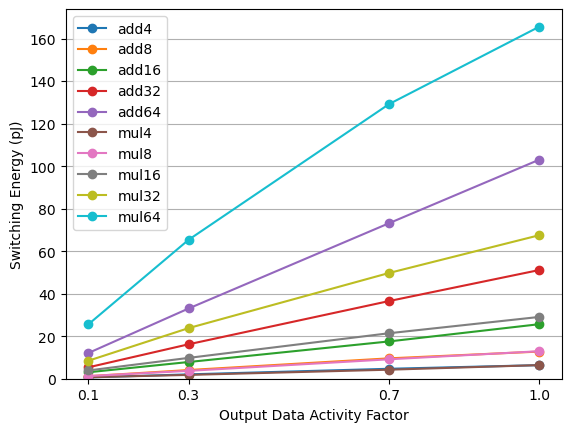

In [16]:
ykey = 'Switching Energy (pJ)'
# ykey = 'Internal (pJ)'

designs =  list(dict.fromkeys(database['design']).keys())
for design in designs:
    df = database[~database['output_af'].isna() & (database['design'] == design)].sort_values('output_af')
    hd = df['output_af']
    e = df[ykey]
    plt.plot(hd,e,'o-',label=design)
    plt.xticks(hd)


plt.legend()
plt.xlabel('Output Data Activity Factor')
plt.ylabel(ykey)
plt.grid(axis='y')
plt.ylim(bottom=0)
;

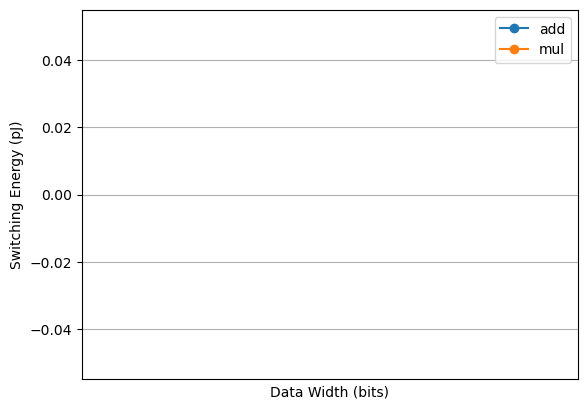

In [17]:
ykey = "Switching Energy (pJ)"

data = database[database['output_af'] == 0.5]
for operation in operations:
    widths, skip = [], []
    ind = 0
    for val in data['design']:
        if operation in val:
            widths.append(int(val.replace(operation,'')))
        else:
            skip.append(ind)
        ind += 1
    energies = data[ykey].values
    valid_energies = []
    for i in range(len(energies)):
        if i not in skip:
            valid_energies.append(energies[i])
    # print(widths, valid_energies)
    plt.plot(widths,valid_energies,'o-', label=operation)
    plt.xticks(widths)
plt.legend()
plt.xlabel("Data Width (bits)")
plt.ylabel(ykey)
plt.grid(axis='y')



## Notes
What do we want to test?

Inputs:
* 0 -> 0
* 0 -> 11...11
* different activity factors of adds

Designs:
* minimum critical path - can we force the synthesis tool to use faster gates

Flow:
* sim-rtl > power-rtl